# Speaker Recommender System (Notebook)

This notebook contains the first development of the speaker recommender system. 

## How it works (overview)

The recommender system developed here shall hold a data frame of several different public address (PA) speaker products and their specifications. The user interacts with the system by providing/selecting a list of products which are liked and disliked based on prior experience. The recommender system will then return ranked lists of new similar products. 

In the background, the recommender system will map product specs to vectors in a high-dimensional feature space, and compare available product vectors to a new vector constructed from the preferences. To compare vectors, the system will use Euclidean or cosine similarity distance measures between vectors. 

In [79]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import time
import re
import ast

import matplotlib 
from matplotlib import pyplot as plt
%matplotlib notebook

## Getting Data

First: teach yourself BeautifulSoup... (3 hours later) - Done & Ready

Here we first scrape a Guitar Center catalogue of PA speakers for basic info like name, price and url.
We are sure to kindly add sleeps to not overload the server. Below we shall access these pages individually to extract specification data.

### Getting product name, prices, and urls

In [ ]:
# Make dataframe to store core product info from catalog
df = pd.DataFrame(columns = ['name','url', 'price' , 'id'])

# Checked 69 pages online
last_page = 69

# loop over all pages and get basic info
for i in range(1,last_page + 1):
    
    page_key = 30*(i-1)
    url = 'https://www.guitarcenter.com/PA-Speakers.gc#pageName=subcategory-page&N=19616&Nao='\
    + str(page_key)\
    +'&recsPerPage=30&postalCode=29212&radius=100&profileCountryCode=US&profileCurrencyCode=USD'
    
    
    soup = BeautifulSoup(requests.get(url, timeout=3).text) # get page
    
    grid = soup.find("div", {"class": "productGrid product-grid"}) # get inside grid

    products = grid.find_all("div", {"class": "productDetails"}) # get inside product details

    # go over product info and store in data frame
    for item in products:
        
        item_title = item.find("div", {"class":"productTitle"})
        item_name = item_title.find("a").get_text().replace('\n','')
        item_href = 'https://guitarcenter.com'+item_title.find("a")['href']
        item_id = item.find("var", {"class": re.compile("productId")}).get_text().split('site')[1]
        item_price = item.find("span", {"class": re.compile("productPrice")}).get_text().split('$')[1] 

        df = df.append(pd.Series({'name': item_name,'url':item_href, 'price':item_price, 'id': item_id}),ignore_index=True)
        
    
    time.sleep(0.5)
    
    print(i, ' of ', last_page)
    
# save data to file
df.to_csv('GC.csv',index=False)

In [3]:
# load from csv into dataframe
df = pd.read_csv('GC.csv')
df.head()

,name,url,price,id
0,"QSC K12.2 Powered 12"" 2-way Loudspeaker System...",https://guitarcenter.com/QSC/K122-Powered-12-2...,799.99,51500000000033476
1,"Harbinger VARI V2312 12"" 2,000W Powered Speake...",https://guitarcenter.com/Harbinger/VARI-V2312-...,249.99,51500000000250906
2,QSC KW153 Active Loudspeaker 1000 Watt 15 Inch...,https://guitarcenter.com/QSC/KW153-Active-Loud...,"1,599.99",51378417699878
3,"QSC K10.2 Powered 10"" 2-way Loudspeaker System...",https://guitarcenter.com/QSC/K102-Powered-10-2...,699.99,51500000000033443
4,"Harbinger VARI V2315 15"" Powered Speaker with ...",https://guitarcenter.com/Harbinger/VARI-V2315-...,299.99,51500000000250907


In [4]:
# Product & Price Info

print('\n total products:', len(df.index))
min_price =  df['price'].apply(lambda x : x.replace(',','')).astype(float).min()
max_price =  df['price'].apply(lambda x : x.replace(',','')).astype(float).max()
print('\n price range:', min_price, '-',max_price)


 total products: 2070

 price range: 229.99 - 2699.0


### Get specs for each product

In [ ]:
# list to array
def Enquiry(lis1): 
    return(np.array(lis1)) 

# define function that takes url and gets specs
def get_specs(url):
# for a single url get the specifications in a list of lists
# outermost list points to specification categories
# within each compartment, we have  [category title , [list of specs for category] ] 
    
    soup_prod = BeautifulSoup(requests.get(url, timeout=3).text)
    time.sleep(0.4)
    
    section = soup_prod.find('section', {'id': "product-specifications"})
    
    d = []
    
    if section != None:
        
        print('There are specs!')
        
        spec_parts = [ item.get_text() for item in section.find_all('strong')]
        
        if (spec_parts != None) and (Enquiry(spec_parts).size):
            
            print('There are subcategories!')
            
            for part in spec_parts:
                
                ## make list of specs
                
                ul = section.find("strong", string = part).next_sibling
                
                li_list = ul.findAll('li')
                
                part_list = [li.get_text() for li in li_list]
                
                d.append([part,part_list])
            
            return d
    
        else:
        
            print('Specs are not categorized!')
            
            ul = section.find("ul")
            
            if ul != None:
                
                ## make list of specs
                
                li_list = ul.findAll('li')

                spec_list = [li.get_text() for li in li_list]

                d.append(['Raw Specs',spec_list])

                return d            
    
    print('Product with no specs!')
    return d

In [ ]:
### Run a loop over the products and store spec lists as object in the dataframe###

iterator = df.index.values 

df['Specs'] = ""
for i in iterator:
    
    spec_list = get_specs(df.loc[i,'url'])
    df['Specs'][i] = spec_list
    
    print(i, ' of ', iterator[-1])      
    
# Consider only objects with non-empty specs
df = df[df.astype(str)['Specs'] != '[]']

In [ ]:
# save to csv
df.to_csv('GC_specs.csv',index=False)

In [9]:
df = pd.read_csv('GC_specs.csv')
df.head()

,name,url,price,id,Specs
0,"QSC K12.2 Powered 12"" 2-way Loudspeaker System...",https://guitarcenter.com/QSC/K122-Powered-12-2...,799.99,51500000000033476,"[['Speaker configuration ', ['Active/passive: ..."
1,"Harbinger VARI V2312 12"" 2,000W Powered Speake...",https://guitarcenter.com/Harbinger/VARI-V2312-...,249.99,51500000000250906,"[['Speaker Configuration\t\t', ['\tActive/pass..."
2,QSC KW153 Active Loudspeaker 1000 Watt 15 Inch...,https://guitarcenter.com/QSC/KW153-Active-Loud...,"1,599.99",51378417699878,"[['KW-153', ['Configuration 15"" 3-way trapezoi..."
3,"QSC K10.2 Powered 10"" 2-way Loudspeaker System...",https://guitarcenter.com/QSC/K102-Powered-10-2...,699.99,51500000000033443,"[['Speaker configuration', [' Active/passive: ..."
4,"Harbinger VARI V2315 15"" Powered Speaker with ...",https://guitarcenter.com/Harbinger/VARI-V2315-...,299.99,51500000000250907,"[['Speaker Configuration', ['\t\t\tActive/pass..."


## Probing and Cleaning the Spec Data 

In [14]:
# how many unique names did we get
print('total indices:',len(df.index.values))

print('total unique:',len(set(df['name'])))
set(df['name'])

total indices: 1518
total unique: 22


{'Alto TS312 12" 2-Way Powered Loudspeaker',
 'Alto TS315 15" 2-Way Powered Loudspeaker',
 'Bose F1 Model 812 Flexible Array Loudspeaker',
 'Bose L1 Compact System',
 'Electro-Voice EKX-12P Powered 12" 2-Way Speaker US',
 'Electro-Voice EKX-15P Powered 15" 2-Way Speaker',
 'Electro-Voice ETX-35P 15" Three-Way Powered Loudspeaker',
 'Electro-Voice ZLX-12P 12" 2-Way Powered Loudspeaker',
 'Electro-Voice ZLX-15P 15" 2-Way Powered Loudspeaker',
 'Harbinger VARI V2312 12" 2,000W Powered Speaker with Bluetooth',
 'Harbinger VARI V2315 15" Powered Speaker with Bluetooth',
 'JBL EON 615 1000 Watt Powered 15" Two-way Loudspeaker System with Bluetooth...',
 'JBL SRX835P 3-Way Active 15" PA Speaker',
 'JBL VRX932LAP 12 IN 2-Way Active Line Array',
 'Mackie Thump 15A 15 in. Powered Loudspeaker',
 'QSC CP12 12" Powered Speaker',
 'QSC CP8 8" Powered Speaker',
 'QSC K10.2 Powered 10" 2-way Loudspeaker System with Advanced DSP',
 'QSC K12.2 Powered 12" 2-way Loudspeaker System with Advanced DSP',
 'Q

We only have 22 unique PA speaker items in Guitar Center; this means Guitar Center has multiple postings with the same product name. For a premilinary model of the recommender system this is ok. However, for a more complete recommender system, we would like many more products and a much larger variety of specifications.   

While we are in the spirit of simplifying to establish a proof of concept, let us remove also those un-structured specs with "Raw Specs" labels, which will take a substantial more time to clean. Additionally, we shall focus on structured specs which have identified 6 categories, although this is not necessary more generally. 

In [15]:
print(len(df['Specs'][df['Specs'].apply(lambda x: ast.literal_eval(x)[0][0])!='Raw Specs'].index))
df = df[df['Specs'].apply(lambda x: ast.literal_eval(x)[0][0])!='Raw Specs']

1173


In [55]:
# create new reduced dataframe with 6 spec categories for all uniques products
dfr = df[df['Specs'].apply(lambda x: len(ast.literal_eval(x)))==6]
dfr = dfr.drop_duplicates(['name'])
dfr.reset_index(inplace=True,drop=True)

print('test products:',len(dfr.index.values))

dfr.head()

test products: 13


,name,url,price,id,Specs
0,"QSC K12.2 Powered 12"" 2-way Loudspeaker System...",https://guitarcenter.com/QSC/K122-Powered-12-2...,799.99,51500000000033476,"[['Speaker configuration ', ['Active/passive: ..."
1,"Harbinger VARI V2312 12"" 2,000W Powered Speake...",https://guitarcenter.com/Harbinger/VARI-V2312-...,249.99,51500000000250906,"[['Speaker Configuration\t\t', ['\tActive/pass..."
2,"QSC K10.2 Powered 10"" 2-way Loudspeaker System...",https://guitarcenter.com/QSC/K102-Powered-10-2...,699.99,51500000000033443,"[['Speaker configuration', [' Active/passive: ..."
3,"Harbinger VARI V2315 15"" Powered Speaker with ...",https://guitarcenter.com/Harbinger/VARI-V2315-...,299.99,51500000000250907,"[['Speaker Configuration', ['\t\t\tActive/pass..."
4,"Electro-Voice EKX-15P Powered 15"" 2-Way Speaker",https://guitarcenter.com/Electro-Voice/EKX-15P...,899.00,51425312342631838082,"[['Speaker configuration', ['Active/passive: A..."


In [56]:
# spec categories
[dfr['Specs'].apply(lambda x: ast.literal_eval(x)[0][0])[0],\
 dfr['Specs'].apply(lambda x: ast.literal_eval(x)[1][0])[0],\
 dfr['Specs'].apply(lambda x: ast.literal_eval(x)[2][0])[0],\
 dfr['Specs'].apply(lambda x: ast.literal_eval(x)[3][0])[0],\
 dfr['Specs'].apply(lambda x: ast.literal_eval(x)[4][0])[0],\
 dfr['Specs'].apply(lambda x: ast.literal_eval(x)[5][0])[0]]

['Speaker configuration ',
 'Power amp (active)',
 'Audio',
 'Enclosure',
 'Inputs',
 'Output/thru']

Within each of the above categories there are different specs.

In [57]:
#Rename & Organize list of specs

def replace_name(s):
    
    if 'config' in s.lower():
        return 'config'
    
    if 'power' in s.lower():
        return 'power'
    
    if 'audio' in s.lower():
        return 'audio'
    
    if 'enclosure' in s.lower():
        return 'enclosure'
    
    if 'output' in s.lower():
        return 'output'
    
    if 'input' in s.lower():
        return 'input'

def clean_specs(x):
    
    new_x = ast.literal_eval(x)
    
    names = [replace_name(n[0]) for n in new_x]
    
    for i in range(len(new_x)):
        new_x[i][0] = names[i]
        
    ordered_names = ['config','power','audio','enclosure','input','output']
    
    
    new_x.sort(key=lambda n: ordered_names.index(n[0]))
    new_names = [n[0] for n in new_x]
    
    # re-order names
    
    re.compile(r'[\n\r\t]')
    
    new_x = [[n[0],[ re.sub(r'\s', ' ', j).strip() for j in n[1]]] for n in new_x]
    
    return new_x

In [58]:
dfr['Specs'].apply(lambda x: clean_specs(x))[2]

[['config',
  ['Active/passive: Active',
   'Type: 2-way full-range',
   'LF driver: 10"',
   'MF driver: Not applicable',
   'HF driver: 1.4"']],
 ['power',
  ['Amplifier type: D',
   'Wattage: 1,012W continuous; 2,000W peak',
   'Mixer/preamp: No']],
 ['audio',
  ['Frequency response: 56Hz–20kHz',
   'Coverage pattern: 90° axisymetric',
   'Max SPL: 130dB']],
 ['enclosure',
  ['Construction: ABS',
   'Width: 12.6" (320 mm)',
   'Height: 20.4" (519 mm)',
   'Depth: 11.8" (300 mm)',
   'Weight: 32 lb. (14.5 kg)']],
 ['input',
  ['XLR/TRS: Combo 2',
   'XLR: Not applicable',
   'TRS: Not applicable',
   'TS: Not applicable',
   'RCA: Not applicable',
   'SPEAKON: Not applicable']],
 ['output',
  ['XLR: 1',
   'TRS: Not applicable',
   'TS: Not applicable',
   'RCA: Not applicable',
   'SPEAKON: Not applicable']]]

Great! Look at those specs. 

I have an intuition for some of them like wattage or weight. Idea: get better intuition by talking to a friend that knows more about PA speakers. Question: What features are essential for buyer choice? 

(1 hour later) Just talked to expert. 

Here are the following specs that are most relevant for buyers (according to an expert):
* Weight (in)
* Height (in)
* Depth (in)
* Width (in)
* max SPL (dB) : max loudness
* coverage : directional angle extent of sound
* high frequency (kHz) : max frequency 
* low frequency (Hz) : min frequency 
* Wattage (Watts): peak power
* LF driver (in) : low frequency driver diameter
* HF driver (in) : high frequency driver diameter

Let's focus on these for now, as they are easily quantifiable. Later we can extend to more feature if desired.

In [59]:
Qs = ['weight','height','depth','width', 'max spl', 'coverage',\
              'frequency', 'wattage', 'lf driver', 'hf driver']

## Building vectors from specifications

In [60]:
# Make function that get numbers and units from a string
def nu_lists(s):
    l = []
    u = []
    for i,t in enumerate(s):
        try:
            l.append(float(t))
            try:
                u.append(s[i+1])
            except:
                u.append('')
        except ValueError:
            pass
        
    return l, u

# Make function that gets a specs list and extracts a vector
def spec_to_vec(specs):
    
    a = []
    
    # get all characteristics
    for n in specs: 
        #print(n)
        for j in n[1]:
            a.append(j)
    
    # give numbers space and collect them
    quantities = []
    numbers = []
    units = []
    for i,s in enumerate(a):
        
        a[i] = re.sub(r"([0-9]+)\,([0-9]+)?",r" \1\2 ", s)
        a[i] = re.sub(r"([0-9]+(\.[0-9]+)?)(\D)",r" \1 \3", a[i])

        s_new=a[i]
        s_new = s_new.split()

        for q in Qs:
            
            if q in s.lower():
                
                num_list, unit_list = nu_lists(s_new)
                
                # if only 1 number in the spec item, 
                # it can be unambiguously set
                if len(num_list) == 1:
                    quantities.append(q)
                    
                    #make sure dimensions are specified in inches (and not mm)
                    if q in ['height','depth','width']:
                        
                        if ('in' in unit_list[0]) or ('"' in unit_list[0]):

                            numbers.append(num_list[0])
                            units.append(unit_list[0])

                        elif ('mm' in unit_list[0]):
                            numbers.append((0.0393701)*num_list[0])
                            units.append(unit_list[0])
                        else:
                            numbers.append(0)
                            units.append('')
                            
                        continue
                    
                    numbers.append(num_list[0])
                    units.append(unit_list[0])
                    
                    
                # if more than 1 number in the spec item, 
                # it must be carefully selected.
                
                # e.g. some vendors have listed dimensions 
                # in inches or mm or both - pick inches.
                else:
                    
                    if len(num_list) == 0:
                        continue
                        
                    # break down frequency specs into low (0) and high (1) frequency
                    if q == 'frequency':

                        quantities.append( q + '_' + str(0))
                        numbers.append(num_list[0])
                        units.append(unit_list[0])
                        
                        quantities.append( q + '_' + str(1))
                        numbers.append(num_list[1])
                        units.append(unit_list[1])
                        
                        continue

                    # get peak wattage, not rms
                    if q == 'wattage':

                        quantities.append( q )
                        numbers.append(num_list[-1])
                        units.append(unit_list[-1])
                        
                        continue
                    
                    # coverage sometimes comes with a range of angles
                    # average min and max angle.
                    if q == 'coverage':

                        quantities.append( q )
                        numbers.append(0.5*(num_list[0] + num_list[1] ) )
                        units.append(unit_list[1])
                        
                        continue
                        
                    if q == 'weight':

                        quantities.append( q )
                        
                        if 'lb' in unit_list[0]:
                            numbers.append(num_list[0])
                            units.append(unit_list[0])
                            
                        elif 'lb' in unit_list[1]:
                            numbers.append(num_list[1])
                            units.append(unit_list[1])
                        else:
                            numbers.append(0)
                            units.append('')
                        
                        continue
                        
                    # All other q's have units of length. Make sure to pick inches.
                    quantities.append( q )
                    if ('in' in unit_list[0]) or ('"' in unit_list[0]):
                    
                        numbers.append(num_list[0])
                        units.append(unit_list[0])

                    elif ('in' in unit_list[1]) or ('"' in unit_list[1]):
                        numbers.append(num_list[1])
                        units.append(unit_list[1])
                    else:
                        numbers.append(0)
                        units.append('')
                    
    
    return [quantities, numbers, units]

In [61]:
# for example, for a single spec list
spec_to_vec(dfr['Specs'].apply(lambda x: clean_specs(x))[2])

[['lf driver',
  'hf driver',
  'wattage',
  'frequency_0',
  'frequency_1',
  'coverage',
  'max spl',
  'width',
  'height',
  'depth',
  'weight'],
 [10.0, 1.4, 2000.0, 56.0, 20.0, 90.0, 130.0, 12.6, 20.4, 11.8, 32.0],
 ['"', '"', 'W', 'Hz–', 'kHz', '°', 'dB', '"', '"', '"', 'lb.']]

In [62]:
### Loop through all products and specs, and get dataframe of vectors (one row for each product)

dfq = dfr.copy()

Qcol = ['weight','height','depth','width', 'max spl', 'coverage',\
              'frequency_0','frequency_1', 'wattage', 'lf driver', 'mf driver', 'hf driver']

dfq = pd.concat([dfq, pd.DataFrame(columns = Qcol)])

for i in dfq.index.values: 
    
    [qs, nums, us] = spec_to_vec(dfq['Specs'].apply(lambda x: clean_specs(x))[i])
    
    for j,q in enumerate(qs):
        
        dfq.loc[i,q] = nums[j]
    
    #print(i, ' of ', dfq.index.values[-1])      
    
dfq.drop(['Specs','mf driver','id','name','price','url'],axis=1,inplace=True)
dfq.head()

/Users/tamiro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,coverage,depth,frequency_0,frequency_1,height,hf driver,lf driver,max spl,wattage,weight,width
0,75,13.8,50,20,23.7,1.4,12,132,2000,47.8,14
1,NaN,14.2,40,20,24.1,NaN,12,126,2000,35,14.2
2,90,11.8,56,20,20.4,1.4,10,130,2000,32,12.6
3,NaN,15,40,20,27.1,NaN,15,127,2000,41,16.5
4,75,16.9,40,180,27,1,15,134,1500,53.8,17


In [63]:
# Make sure that all values are within a physically reasonable range

print('coverage_min:',dfq['coverage'].min())
print('coverage_max:',dfq['coverage'].max())
print('depth_min:',dfq['depth'].min())
print('depth_max:',dfq['depth'].max())
print('width_min:',dfq['width'].min())
print('width_max:',dfq['width'].max())
print('height_min:',dfq['height'].min())
print('height_max:',dfq['height'].max())
print('weight_min:',dfq['weight'].min())
print('weight_max:',dfq['weight'].max())
print('spl_min:',dfq['max spl'].min())
print('spl_max:',dfq['max spl'].max())
print('lf_min:',dfq['lf driver'].min())
print('lf_max:',dfq['lf driver'].max())
print('hf_min:',dfq['hf driver'].min())
print('hf_max:',dfq['hf driver'].max())

coverage_min: 75.0
coverage_max: 105.0
depth_min: 10.1
depth_max: 16.9
width_min: 10.7
width_max: 17.0
height_min: 16.2
height_max: 27.1
weight_min: 21.0
weight_max: 53.8
spl_min: 124.0
spl_max: 134.0
lf_min: 8.0
lf_max: 15.0
hf_min: 1.0
hf_max: 1.5


Good!, no abnormally large or small values

In [70]:
# Handle missing values

# for drivers, if there is a missing value the driver is probably absent, set to 0.0
dfq['hf driver'] =dfq['hf driver'].fillna(0.0)
dfq['lf driver'] =dfq['lf driver'].fillna(0.0)

# for all other quantities like depth, width or frequency, 
# it makes sense to set missing values to average of respective column.
dfq = dfq.fillna(dfq.mean())

# check if there are still unaccounted for values
dfq.isnull().values.any()

dfq.head()

,coverage,depth,frequency_0,frequency_1,height,hf driver,lf driver,max spl,wattage,weight,width
0,75.000000,13.8,50.0,20.0,23.7,1.4,12.0,132.0,2000.0,47.8,14.0
1,81.666667,14.2,40.0,20.0,24.1,0.0,12.0,126.0,2000.0,35.0,14.2
2,90.000000,11.8,56.0,20.0,20.4,1.4,10.0,130.0,2000.0,32.0,12.6
3,81.666667,15.0,40.0,20.0,27.1,0.0,15.0,127.0,2000.0,41.0,16.5
4,75.000000,16.9,40.0,180.0,27.0,1.0,15.0,134.0,1500.0,53.8,17.0


### Feature Normalization 

In [66]:
### make normalized vectors for every entry. ###

# mean-normalization
dfmat_norm = (dfq - dfq.mean()) / (dfq.max() - dfq.min())
print( 'entries:', len(dfmat_norm.index.values))
dfmat_norm.head()

entries: 13


,coverage,depth,frequency_0,frequency_1,height,hf driver,lf driver,max spl,wattage,weight,width
0,-2.222222e-01,0.072059,-0.007273,-0.088664,0.115596,0.174359,-0.021978,0.363636,0.384615,0.358841,0.023016
1,4.736952e-16,0.130882,-0.407273,-0.088664,0.152294,-0.758974,-0.021978,-0.236364,0.384615,-0.031402,0.054762
2,2.777778e-01,-0.222059,0.232727,-0.088664,-0.187156,0.174359,-0.307692,0.163636,0.384615,-0.122866,-0.199206
3,4.736952e-16,0.248529,-0.407273,-0.088664,0.427523,-0.758974,0.406593,-0.136364,0.384615,0.151524,0.419841
4,-2.222222e-01,0.527941,-0.407273,0.898990,0.418349,-0.092308,0.406593,0.563636,-0.115385,0.541768,0.499206


In [68]:
# save feature matrix to csv file to quick access.

dfmat_norm.to_csv('f_mat.csv',index=False)

## Visualizations & Explorations

In [76]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

import plotly.graph_objs as go

In [77]:
# Class will be used to easily draw arrows in 3D plots below

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

### Visualizing vectors 

To visualize the vectors, since our senses only have access to 3 dimensions, we probe three dimensions at a time.
The following plots show all product vectors, as points in 3D space. To build the 3D space, we choose only 3 features of the products by index, using the idx_feat = [feature1, feature2,feature3].

<IPython.core.display.Javascript object>


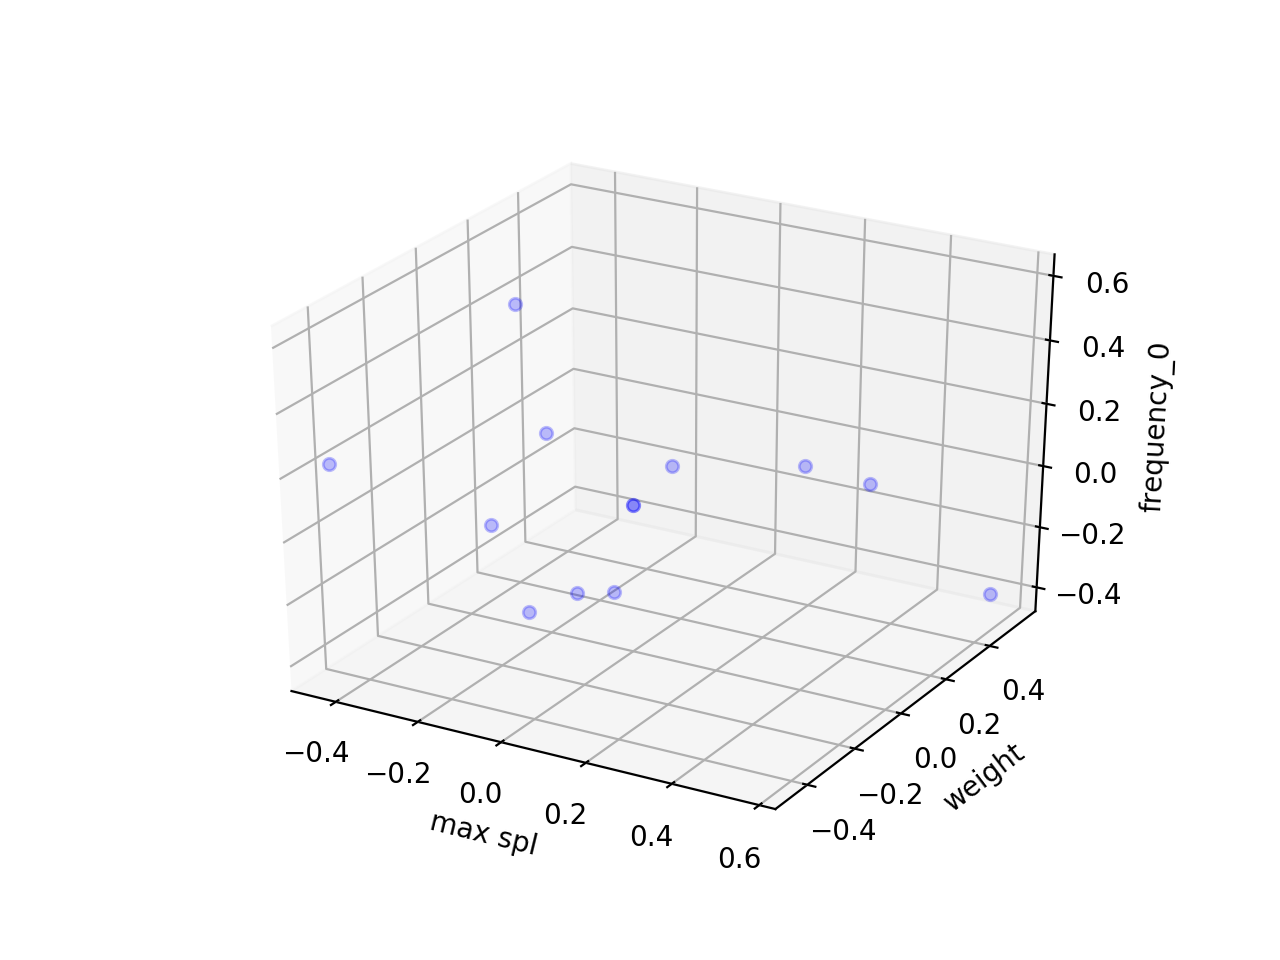

In [80]:
fig = plt.figure()
ax = plt.axes(projection='3d')

idx_feat = [7,9,2]

mat = dfmat_norm.to_numpy()
#print(dfmat_norm[1,2])

for name in  dfr['name']:
    
    idx = dfr['name'][dfr['name']==name].index.values[0]
    #print(idx)
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    #proj_vec = np.array([dfmat_norm[idx,idx_feat[0]], dfmat_norm[idx,idx_feat[1]] , dfmat_norm[idx,idx_feat[2]]])
    
    ax.scatter3D(xdata, ydata, zdata, c='b',marker='o',alpha=0.25); #, cmap='Greens'
    #ax.text3D(xdata,ydata,zdata, '%s' + str(idx), size=20, color='k') #, zorder=1

ax.set_xlabel(dfmat_norm.columns[idx_feat[0]])
ax.set_ylabel(dfmat_norm.columns[idx_feat[1]])
ax.set_zlabel(dfmat_norm.columns[idx_feat[2]])
          
plt.show()

<IPython.core.display.Javascript object>


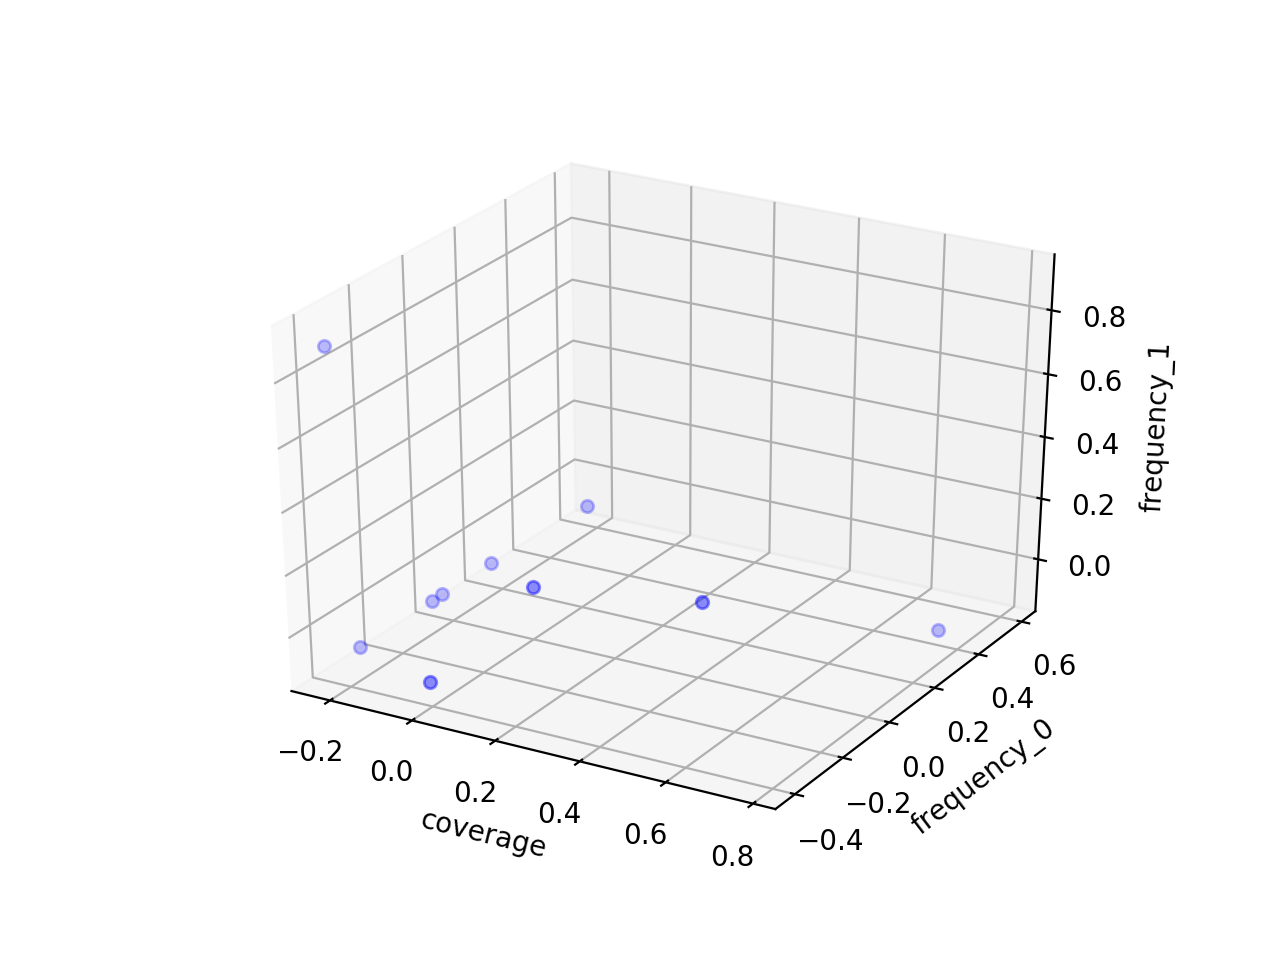

In [93]:
fig = plt.figure()
ax = plt.axes(projection='3d')

idx_feat = [0,2,3]

mat = dfmat_norm.to_numpy()
#print(dfmat_norm[1,2])

for name in  dfr['name']:
    
    idx = dfr['name'][dfr['name']==name].index.values[0]
    #print(idx)
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    #proj_vec = np.array([dfmat_norm[idx,idx_feat[0]], dfmat_norm[idx,idx_feat[1]] , dfmat_norm[idx,idx_feat[2]]])
    
    ax.scatter3D(xdata, ydata, zdata, c='b',marker='o',alpha=0.25); #, cmap='Greens'
    #ax.text3D(xdata,ydata,zdata, '%s' + str(idx), size=20, color='k') #, zorder=1

ax.set_xlabel(dfmat_norm.columns[idx_feat[0]])
ax.set_ylabel(dfmat_norm.columns[idx_feat[1]])
ax.set_zlabel(dfmat_norm.columns[idx_feat[2]])
          
plt.show()

Playing around with several choices of indices, we find that most features are dispered around the [-1,1]x[-1,1]x[-1,1] grid box, not bunching up in particular regions (like the first example plot above). This is positive, as it indicates that there is enough separation between the products to justify distinguishing them by the chosen features. Other features such as coverage or high-frequency (frequency_1) show a bit more clustering, since these features have a couple of standard values across all products in the list - (see second exaxmple plot); we wouldn't want to base the recommender system solely on this parameters. Fortunately, the recommender system proposed uses all the features, and there are enough of them which are well separated to merit comparing their vectors to determine similarity.

# Recommender System

We are now ready to test a basic recommender system.

The user shall feed a list of items which are liked and disliked:

In [96]:
likes = [dfr.loc[0,'name'], dfr.loc[3,'name']]
dislikes =  [dfr.loc[2,'name'], dfr.loc[7,'name']]

total = len(likes)+len(dislikes)

In an app this like/dislike selection would be interactive.

### Create preference vector and visualize it

The (ideal) preference vector is the weighted average over all likes (+1) and dislikes (-1).
Essentially, it is a vector that tries to look as much as possible like the vectors for the 'liked' products, and be the least like the 'disliked' products. See visual below.

<IPython.core.display.Javascript object>


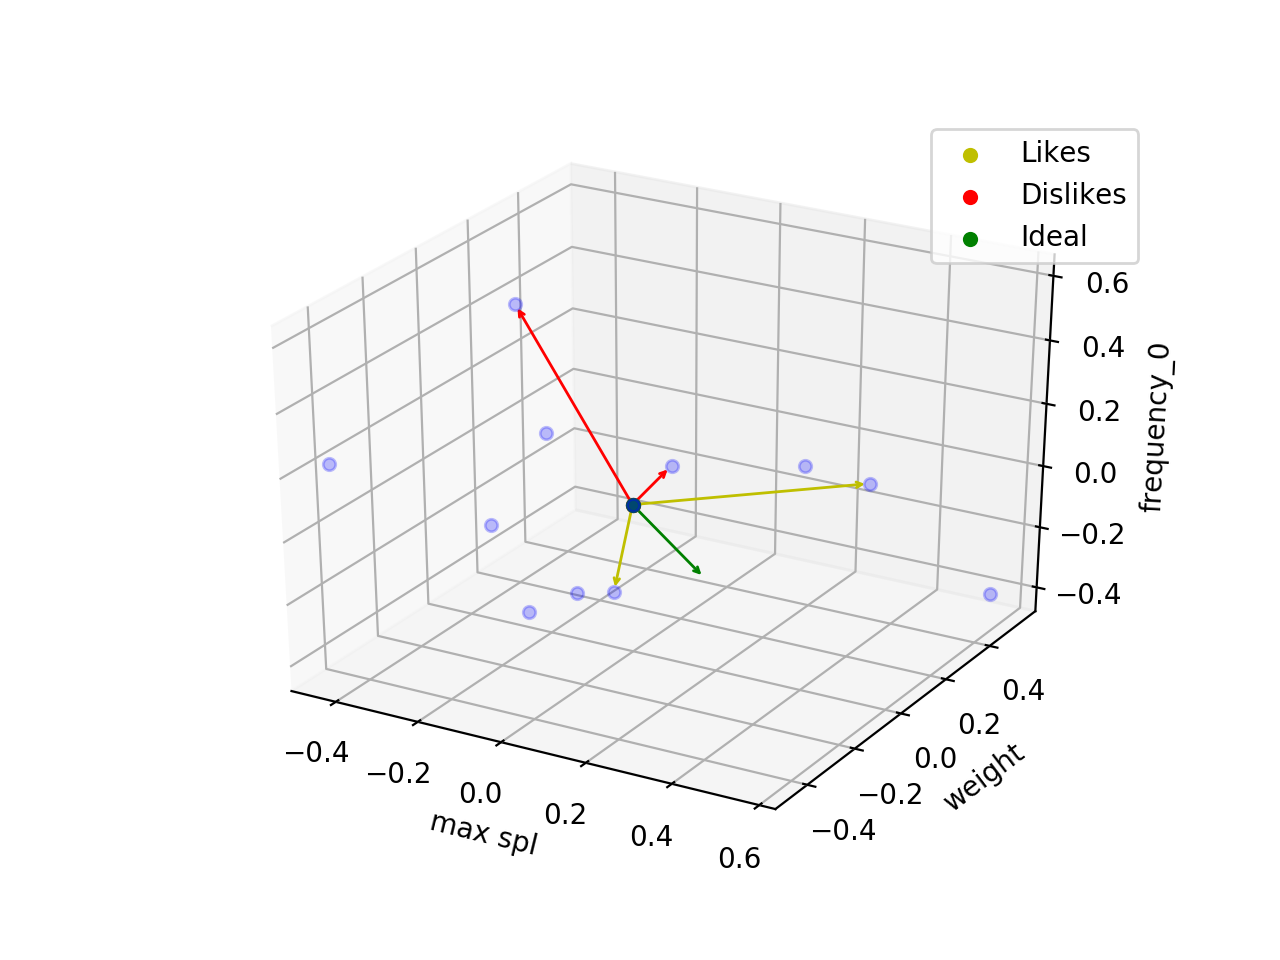

In [100]:
fig = plt.figure()
ax = plt.axes(projection='3d')

idx_feat = [7,9,2] # pick some index features for visualization

vec = np.zeros((1,dfmat_norm.shape[1]))
mat = dfmat_norm.to_numpy()
#print(dfmat_norm[1,2])

ax.scatter3D([0], [0], [0], c='y', alpha=1.0,label = 'Likes');
ax.scatter3D([0], [0], [0], c='r', alpha=1.0,label = 'Dislikes');
ax.scatter3D([0], [0], [0], c='g', alpha=1.0,label = 'Ideal');


for name in  dfr['name']:
    
    idx = dfr['name'][dfr['name']==name].index.values[0]
    #print(idx)
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    #proj_vec = np.array([dfmat_norm[idx,idx_feat[0]], dfmat_norm[idx,idx_feat[1]] , dfmat_norm[idx,idx_feat[2]]])
    
    ax.scatter3D(xdata, ydata, zdata, c='b',marker='o',alpha=0.25); #, cmap='Greens'
    #ax.text3D(xdata,ydata,zdata, '%s' + str(idx), size=20, color='k') #, zorder=1
    
for name in likes:
    
    idx = dfr['name'][dfr['name']==name].index.values[0]
    
    vec += (1.0/total)*mat[idx,:]
    
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="y", lw = 1, mutation_scale=5)
    ax.add_artist(arw)
    #ax.scatter3D(xdata, ydata, zdata, c='y'); #, cmap='Greens'
    
for name in dislikes:

    idx = dfr['name'][dfr['name']==name].index.values[0]
    
    vec -= (1.0/total)*mat[idx,:]
    
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="r", lw = 1, mutation_scale=5)
    ax.add_artist(arw)
    #ax.scatter3D(xdata, ydata, zdata, c='r'); #, cmap='Greens'
             
# final vector
xdata = [vec[0,idx_feat[0]]]
ydata = [vec[0,idx_feat[1]]]
zdata = [vec[0,idx_feat[2]]]

arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="g", lw = 1, mutation_scale=5)
ax.add_artist(arw)

ax.set_xlabel(dfmat_norm.columns[idx_feat[0]])
ax.set_ylabel(dfmat_norm.columns[idx_feat[1]])
ax.set_zlabel(dfmat_norm.columns[idx_feat[2]])

 #, cmap='Greens'
          
plt.legend()
plt.show()

## Use preference vector to generate ranking of recommendations

### Cosine Similarity

Cosine similarity compares vectors by the angles between them; that is, they are close in directionality. In this context, two vectors which are 'cosine-similar' share a similar proportion of features (a balance so to speak), and the scale of the features is not as important as the ratios of specs. For example, if a buyer wants to try a larger speaker which the same balance of features, cosine similarity will be helpful.

In [106]:
def cossim (v1,v2):
    return np.dot(v1,v2)/(np.sqrt(np.dot(v1,v1)*np.dot(v2,v2)))

In [107]:
score_list = []
for name in dfr['name']:
    
    if (name not in likes) and (name not in dislikes) : # we must recommend things consumers have not tried
        
        idx = dfr['name'][dfr['name']==name].index.values[0]
        v1 = vec.flatten()
        v2 = mat[idx,:].flatten()
        
        score_list.append((idx,cossim(v1,v2)))
        
sorted_scores_cossim = sorted(score_list, key=lambda x: x[1],reverse=True)

# print recommendations:

print('Recommendations (Cossim):')
counter = 1
for idx, score in sorted_scores_cossim:

    score_norm = 100*(score+1)/2
    print(str(counter), ' : ', dfr.loc[idx,'name'], ', score = ' , str(int(np.round(score_norm,0)))+'%')
    
    counter += 1

Recommendations (Cossim):
1  :  Harbinger VARI V2312 12" 2,000W Powered Speaker with Bluetooth , score =  86%
2  :  Electro-Voice EKX-15P Powered 15" 2-Way Speaker , score =  79%
3  :  Alto TS315 15" 2-Way Powered Loudspeaker , score =  68%
4  :  Alto TS312 12" 2-Way Powered Loudspeaker , score =  60%
5  :  Electro-Voice EKX-12P Powered 12" 2-Way Speaker US , score =  56%
6  :  Electro-Voice ZLX-15P 15" 2-Way Powered Loudspeaker , score =  47%
7  :  QSC K8.2 Powered 8" 2-way Loudspeaker System with Advanced DSP , score =  23%
8  :  QSC CP12 12" Powered Speaker , score =  22%
9  :  QSC CP8 8" Powered Speaker , score =  8%


### Euclidean Similarity

Euclidean similarity compares vectors by the Euclidean distance between them; that is, they are close in spatial position. In this context, two vectors which are 'Euclidean-similar' share a similar exact ranges of features (features tend to have similar values), and the scale of the features plays a more important role compared to the ratios of specs. For example, if a buyer wants to replace a speaker with a good equivalent, Euclidean similarity will be helpful.

In [108]:
def eucsim (v1,v2):
    #print(v1.flatten().shape)
    #print(v2.flatten().shape)
    return np.sqrt(np.dot(v1-v2,v1-v2))

In [115]:
score_list = []
for name in dfr['name']:
    
    if (name not in likes) and (name not in dislikes) : # we must recommend things consumers have not tried
        
        idx = dfr['name'][dfr['name']==name].index.values[0]
        v1 = vec.flatten()
        v2 = mat[idx,:].flatten()
        
        score_list.append((idx,eucsim(v1,v2)))
        
#print(sorted(score_list, key=lambda x: x[1],reverse=True))
sorted_scores_eucsim = sorted(score_list, key=lambda x: x[1],reverse=False)

print('Recommendations (Euclidean):')
counter = 1
for idx, score in sorted_scores_eucsim:

    score_norm = score
    print(str(counter), ' : ', dfr.loc[idx,'name'], ', score = ' , str(np.round(score_norm,2))+' dist. units')
    
    counter += 1

Recommendations (Euclidean):
1  :  Alto TS312 12" 2-Way Powered Loudspeaker , score =  0.66 dist. units
2  :  Alto TS315 15" 2-Way Powered Loudspeaker , score =  0.67 dist. units
3  :  Harbinger VARI V2312 12" 2,000W Powered Speaker with Bluetooth , score =  0.7 dist. units
4  :  Electro-Voice EKX-12P Powered 12" 2-Way Speaker US , score =  0.76 dist. units
5  :  Electro-Voice ZLX-15P 15" 2-Way Powered Loudspeaker , score =  1.1 dist. units
6  :  QSC CP12 12" Powered Speaker , score =  1.21 dist. units
7  :  Electro-Voice EKX-15P Powered 15" 2-Way Speaker , score =  1.34 dist. units
8  :  QSC K8.2 Powered 8" 2-way Loudspeaker System with Advanced DSP , score =  1.77 dist. units
9  :  QSC CP8 8" Powered Speaker , score =  1.97 dist. units


## Preliminary Validation

To validate the recommender system, we would like to compare it other recommender systems. 

As a test, we focus on the 'similar items' recommendation given in product pages by Guitar Center. Below we have listed some products in our dataframe, together with 3 similar products recommended by Guitar Center.

In [116]:
GCrec = pd.DataFrame(dict({'name': ['QSC K12.2 Powered 12" 2-way Loudspeaker System with Advanced DSP', 'Harbinger VARI V2312 12" 2,000W Powered Speaker with Bluetooth','Harbinger VARI V2315 15" Powered Speaker with Bluetooth'],\
                       'sim_1': ['K10.2 Powered 10" 2-way Loudspeaker System with Advanced DSP','VARI V2315 15" Powered Speaker with Bluetooth Black','VARI V2312 12" 2,000W Powered Speaker with Bluetooth Black'], \
                       'sim_2': ['CP12 12" Powered Speaker','TS312 12" 2-Way Powered Loudspeaker','TS315 15" 2-Way Powered Loudspeaker'] , \
                       'sim_3': ['VARI V2312 12" 2,000W Powered Speaker with Bluetooth Black','VARI V2212 600W 12" Two-Way Class-D Loudspeaker','VARI V2215 600W 15" 2-Way Class D Loudspeaker']}))

GCrec.head()

,name,sim_1,sim_2,sim_3
0,"QSC K12.2 Powered 12"" 2-way Loudspeaker System...","K10.2 Powered 10"" 2-way Loudspeaker System wit...","CP12 12"" Powered Speaker","VARI V2312 12"" 2,000W Powered Speaker with Blu..."
1,"Harbinger VARI V2312 12"" 2,000W Powered Speake...","VARI V2315 15"" Powered Speaker with Bluetooth ...","TS312 12"" 2-Way Powered Loudspeaker","VARI V2212 600W 12"" Two-Way Class-D Loudspeaker"
2,"Harbinger VARI V2315 15"" Powered Speaker with ...","VARI V2312 12"" 2,000W Powered Speaker with Blu...","TS315 15"" 2-Way Powered Loudspeaker","VARI V2215 600W 15"" 2-Way Class D Loudspeaker"


Lets see if we can find some of these recommended items in our dataframe and visualize to get a sense of what comparisson measure Guitar Center is utilizing.

<IPython.core.display.Javascript object>


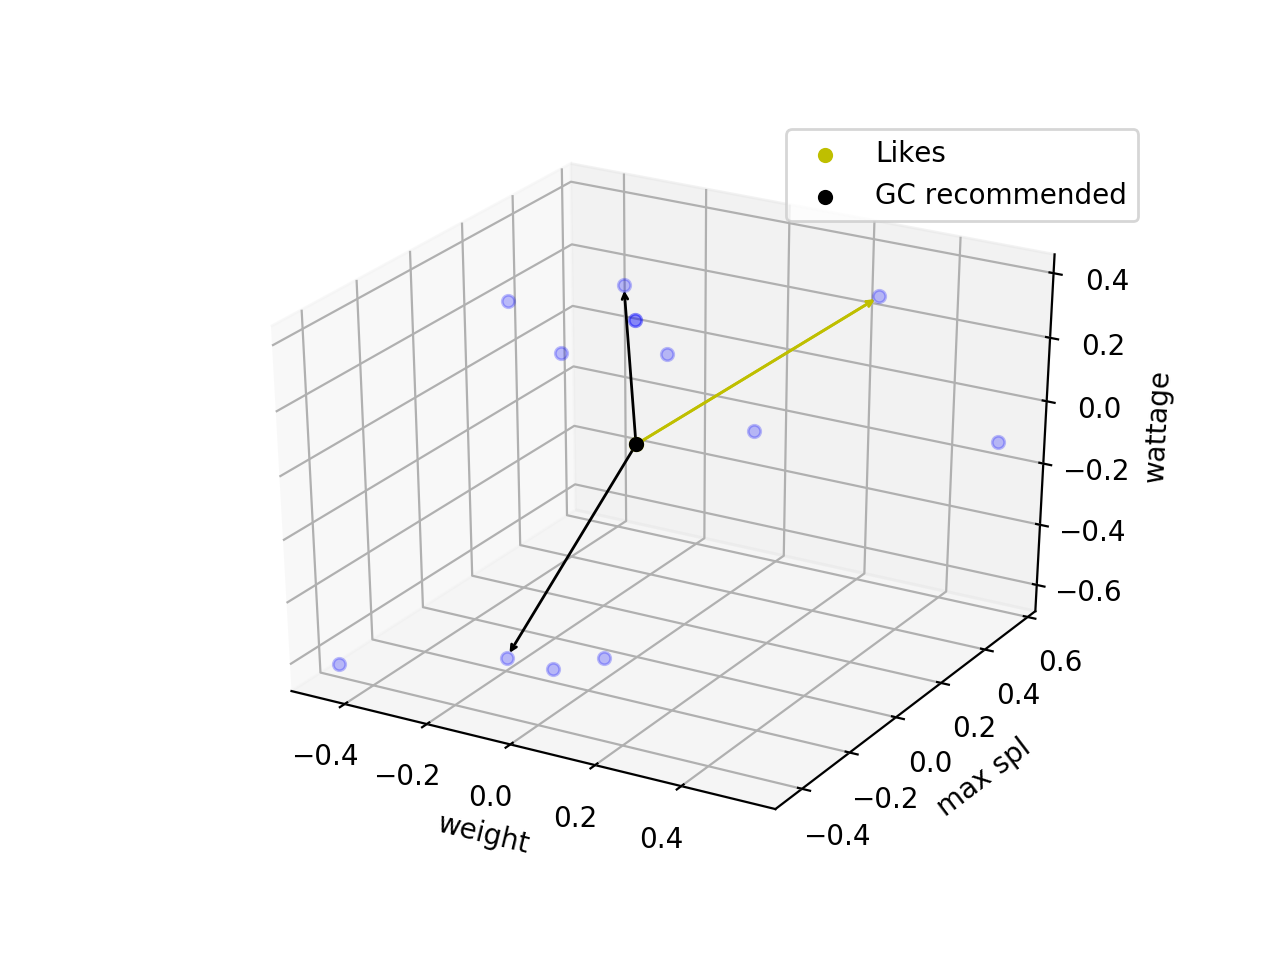

In [127]:
likes = [dfr.loc[0,'name']]
dislikes =  []

total = len(likes)+len(dislikes)

fig1 = plt.figure()
ax = plt.axes(projection='3d')

idx_feat = [1,2,5] #[2,4,6]#[9,7,8]

vec = np.zeros((1,dfmat_norm.shape[1]))
mat = dfmat_norm.to_numpy()

ax.scatter3D([0], [0], [0], c='y', alpha=1.0,label = 'Likes');
ax.scatter3D([0], [0], [0], c='k', alpha=1.0,label = 'GC recommended');

#print(GCrec['name'][0])
#print(dfr['name'].values)

for name in dfr['name']:
    
    idx = dfr['name'][dfr['name']==name].index.values[0]
    
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
  
    ax.scatter3D(xdata, ydata, zdata, c='b',marker='o',alpha=0.25); #, cmap='Greens'
    
for name in likes:
    
    idx = dfr['name'][dfr['name']==name].index.values[0]
    
    vec += (1.0/total)*mat[idx,:]
    
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="y", lw = 1, mutation_scale=5)
    ax.add_artist(arw)

    if name in (GCrec['name'].values):
        
        idx_name = GCrec['name'][GCrec['name']==name].index.values[0]
        #print('there is info to compare!')
        
        for i in range(1,3):
            
            col = 'sim_' + str(i)
            name2 = GCrec.loc[idx_name,col]
            
            
            for dfr_name in dfr['name'].values:
                if name2 in dfr_name:
                
                    #print('info is in assembled dataframe!')

                    idx = dfr['name'][dfr['name']==dfr_name].index.values[0]

                    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
                    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
                    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]

                    arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="k", lw = 1, mutation_scale=5)
                    ax.add_artist(arw)
        
    
for name in dislikes:

    idx = dfr['name'][dfr['name']==name].index.values[0]
    
    vec -= (1.0/total)*mat[idx,:]
    
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="r", lw = 1, mutation_scale=5)
    ax.add_artist(arw)
    
             
# final vector
xdata = [vec[0,idx_feat[0]]]
ydata = [vec[0,idx_feat[1]]]
zdata = [vec[0,idx_feat[2]]]

arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="y", lw = 1, mutation_scale=5)
ax.add_artist(arw)

ax.set_xlabel(dfmat_norm.columns[idx_feat[0]])
ax.set_ylabel(dfmat_norm.columns[idx_feat[1]])
ax.set_zlabel(dfmat_norm.columns[idx_feat[2]])

          
plt.legend()
plt.show()

For this example (and trying different feature combinations), it appears that Guitar Center's recommendation picks out some features as above and recommends products that are similar based on those features. This is not the case for all features combinations as shown below:

<IPython.core.display.Javascript object>


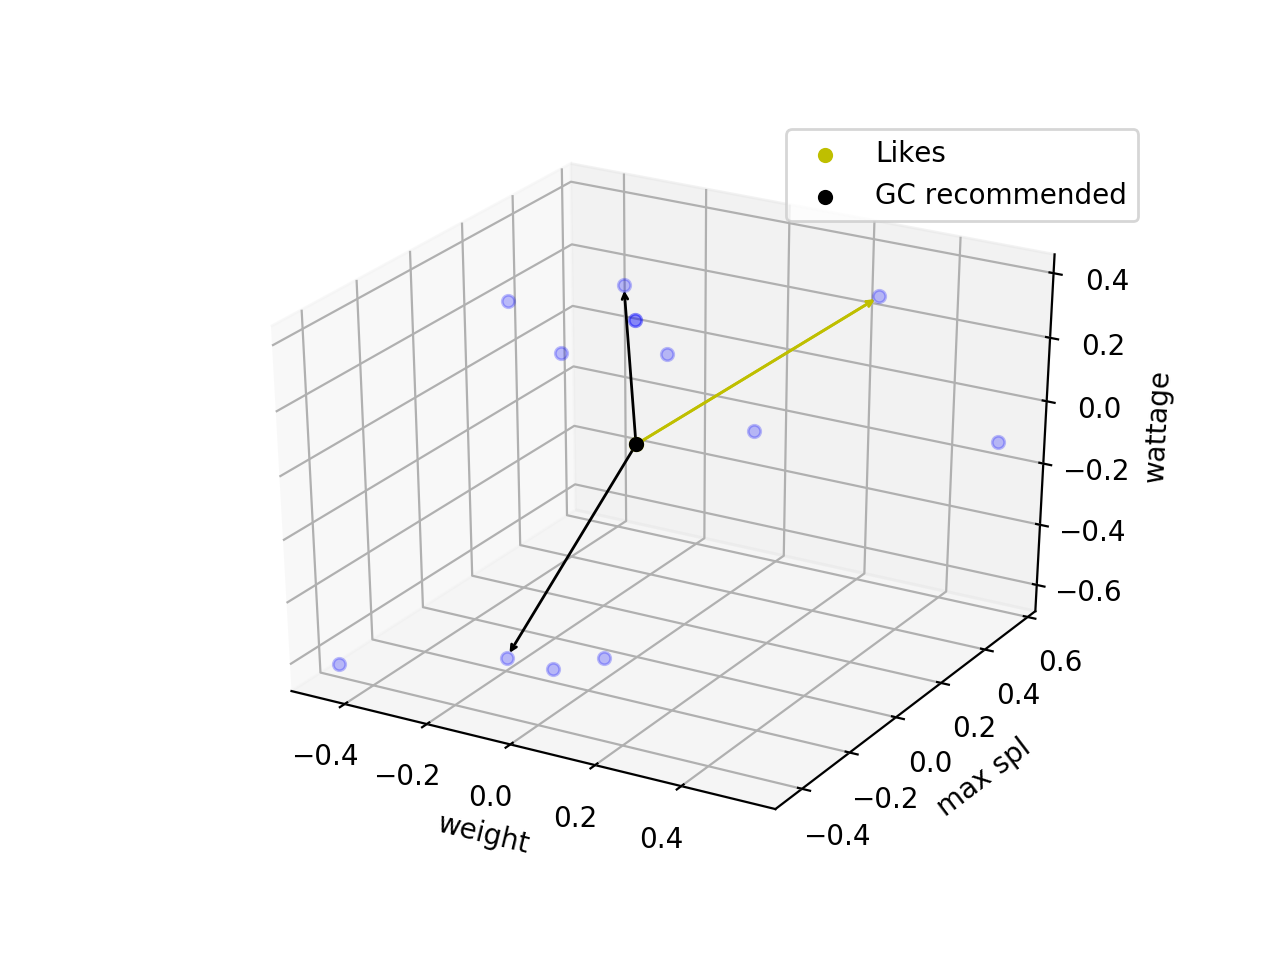

In [128]:
likes = [dfr.loc[0,'name']]
dislikes =  []

total = len(likes)+len(dislikes)

fig1 = plt.figure()
ax = plt.axes(projection='3d')

idx_feat = [9,7,8]

vec = np.zeros((1,dfmat_norm.shape[1]))
mat = dfmat_norm.to_numpy()

ax.scatter3D([0], [0], [0], c='y', alpha=1.0,label = 'Likes');
ax.scatter3D([0], [0], [0], c='k', alpha=1.0,label = 'GC recommended');

#print(GCrec['name'][0])
#print(dfr['name'].values)

for name in dfr['name']:
    
    idx = dfr['name'][dfr['name']==name].index.values[0]
    
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
  
    ax.scatter3D(xdata, ydata, zdata, c='b',marker='o',alpha=0.25); #, cmap='Greens'
    
for name in likes:
    
    idx = dfr['name'][dfr['name']==name].index.values[0]
    
    vec += (1.0/total)*mat[idx,:]
    
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="y", lw = 1, mutation_scale=5)
    ax.add_artist(arw)

    if name in (GCrec['name'].values):
        
        idx_name = GCrec['name'][GCrec['name']==name].index.values[0]
        #print('there is info to compare!')
        
        for i in range(1,3):
            
            col = 'sim_' + str(i)
            name2 = GCrec.loc[idx_name,col]
            
            
            for dfr_name in dfr['name'].values:
                if name2 in dfr_name:
                
                    #print('info is in assembled dataframe!')

                    idx = dfr['name'][dfr['name']==dfr_name].index.values[0]

                    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
                    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
                    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]

                    arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="k", lw = 1, mutation_scale=5)
                    ax.add_artist(arw)
        
    
for name in dislikes:

    idx = dfr['name'][dfr['name']==name].index.values[0]
    
    vec -= (1.0/total)*mat[idx,:]
    
    xdata = [dfmat_norm.iloc[idx,idx_feat[0]]]
    ydata = [dfmat_norm.iloc[idx,idx_feat[1]]]
    zdata = [dfmat_norm.iloc[idx,idx_feat[2]]]
    
    arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="r", lw = 1, mutation_scale=5)
    ax.add_artist(arw)
    
             
# final vector
xdata = [vec[0,idx_feat[0]]]
ydata = [vec[0,idx_feat[1]]]
zdata = [vec[0,idx_feat[2]]]

arw = Arrow3D([0,xdata[0]],[0,ydata[0]],[0,zdata[0]], arrowstyle="->", color="y", lw = 1, mutation_scale=5)
ax.add_artist(arw)

ax.set_xlabel(dfmat_norm.columns[idx_feat[0]])
ax.set_ylabel(dfmat_norm.columns[idx_feat[1]])
ax.set_zlabel(dfmat_norm.columns[idx_feat[2]])

          
plt.legend()
plt.show()

Guitar Center may not be using the full feature space to make recommendations. In addition, when it does base a recommendation on certain features, the Euclidean distance (and not the angular similarity) between features appears to a determining factor in that system. Since our recommendation system uses a high-dimensional feature and is not restricted to Euclidean similarity, it has the potential to outperform the system used by Guitar Center. 

We established the viability of a speaker recommender system. 

To fully establish it we shall:
* Collect and use a larger dataset
* Undergo more extensive cleaning
* Validate it with statistical tests against several other recommender systems
* Creat a web application to interact with the user,and add selection options (e.g. price ranges, brands, etc...)